In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np

In [113]:
import os

import numpy as np
import torch
from torch.utils import data


class ImageDataLoader(data.Dataset):
    "My own Image Loader made to read .npy images"

    def __init__(self, directory, transform=None):

        self.directory = directory
        self.transform = transform
        self.file_names = [
            file
            for file in os.listdir(directory)
            if os.path.isfile(os.path.join(directory, file))
        ]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):

        img_path = os.path.join(self.directory, self.file_names[idx])
        image = np.load(img_path)
        image = image.astype(np.float32)

        if self.transform is not None:
            image = self.transform(image)

        image_labels = torch.zeros(image.shape[0])
        return image, image_labels


class ToTensorWithScaling:
    def __init__(self, min_val: float = 0.0, max_val: float = 1.0, eps: float = 1e-6):
        self.min_val = min_val
        self.max_val = max_val
        self.eps = eps

    def __call__(self, image: np.ndarray):
        image = torch.tensor(image, dtype=torch.float32)
        image = torch.permute(image, (2, 0, 1))

        # Get min and max values for every channel
        min_vals = image.amin(dim=(1, 2), keepdim=True)
        max_vals = image.amax(dim=(1, 2), keepdim=True)

        # [0, 1]
        image = (image - min_vals) / (max_vals - min_vals + self.eps)

        # [min_val, max_val]
        image = image * (self.max_val - self.min_val) + self.min_val

        # # rescale to 28 x 28
        # image = torch.nn.functional.interpolate(
        #     image.unsqueeze(0), (28, 28), mode="bilinear", align_corners=False
        # )
        # keep only 1 channel but keep the dimension
        # image = image.squeeze(0)[0].unsqueeze(0)

        return image

In [122]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 128

PATH_TEST_TYPICAL = "../dataset/test_typical"
PATH_TEST_NOVEL = "../dataset/test_novel/all"

RANDOM_SEED = 42

PATH_TRAIN = "../dataset/train_typical"
PATH_VALIDATION = "../dataset/validation_typical"

transform = ToTensorWithScaling()

# print(model_name, lr, epoch_number, device)

train_dataset = ImageDataLoader(PATH_TRAIN, transform=transform)
valdiaiton_dataset = ImageDataLoader(PATH_VALIDATION, transform=transform)

test_typical_dataset = ImageDataLoader(PATH_TEST_TYPICAL, transform=transform)
test_novel_dataset = ImageDataLoader(PATH_TEST_NOVEL, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valdiaiton_dataset, batch_size=batch_size)

test_typical_loader = DataLoader(test_typical_dataset, batch_size=1)
test_novel_loader = DataLoader(test_novel_dataset, batch_size=1)

### VAE Model

In [102]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.nn.functional as F

pyro.enable_validation(False)


class VEncoder(nn.Module):
    """Encoder for VAE."""

    input_to_hidden: nn.Linear
    hidden_to_mu: nn.Linear
    hidden_to_sigma: nn.Linear
    N: torch.distributions.Normal
    kl: float

    def __init__(
        self,
        n_input_features: int,
        n_hidden_neurons: int,
        n_latent_features: int,
    ):
        """
        :param n_input_features: number of input features (28 x 28 = 784 for MNIST)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_latent_features: size of the latent vector
        """
        super().__init__()

        # TU WPISZ KOD
        self.input_to_hidden = nn.Linear(n_input_features, n_hidden_neurons)
        self.hidden_to_mu = nn.Linear(n_hidden_neurons, n_latent_features)
        self.hidden_to_sigma = nn.Linear(n_hidden_neurons, n_latent_features)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Encode data to gaussian distribution params."""

        # TU WPISZ KOD
        x = F.relu(self.input_to_hidden(x))
        z_loc = self.hidden_to_mu(x)
        # exponential activation to ensure the result is positive
        # z_scale = torch.exp(self.hidden_to_sigma(x))
        z_scale = self.hidden_to_sigma(x).exp()

        return z_loc, z_scale


class VDecoder(nn.Module):
    """Decoder for VAE."""

    def __init__(
        self,
        n_latent_features: int,
        n_hidden_neurons: int,
        n_output_features: int,
    ):
        """
        :param n_latent_features: number of latent features (same as in Encoder)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_output_features: size of the output vector (28 x 28 = 784 for MNIST)
        """
        super().__init__()
        # TU WPISZ KOD
        self.latent_to_hidden = nn.Linear(n_latent_features, n_hidden_neurons)
        self.hidden_to_output = nn.Linear(n_hidden_neurons, n_output_features)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to image."""
        # TU WPISZ KOD
        r = F.relu(self.latent_to_hidden(z))
        r = torch.sigmoid(self.hidden_to_output(r))
        return r


class BaseAutoEncoder(nn.Module):
    """Base AutoEncoder module class."""

    def __init__(self, encoder: nn.Module, decoder: nn.Module, n_latent_features: int):
        """
        :param encoder: encoder network
        :param decoder: decoder network
        :param n_latent_features: number of latent features in the AE
        """
        super().__init__()

        self.n_latent_features: int = n_latent_features

        self.encoder: nn.Module = encoder
        self.decoder: nn.Module = decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward function for mapping input to output."""
        z = self.encoder_forward(x)
        return self.decoder_forward(z)

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.

        takes: tensor of shape [batch_size x input_flattened_size] (flattened input)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        raise NotImplementedError()

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.

        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x output_flattened_size] (flettened output)
        """
        raise NotImplementedError()


class VariationalAutoencoder(BaseAutoEncoder):
    """Variational Auto Encoder model."""

    N: torch.distributions.Normal
    kl: float

    def __init__(
        self,
        n_data_features: int,
        n_encoder_hidden_features: int,
        n_decoder_hidden_features: int,
        n_latent_features: int,
    ):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        """
        encoder = VEncoder(
            n_input_features=n_data_features,
            n_hidden_neurons=n_encoder_hidden_features,
            n_latent_features=n_latent_features,
        )
        decoder = VDecoder(
            n_latent_features=n_latent_features,
            n_hidden_neurons=n_decoder_hidden_features,
            n_output_features=n_data_features,
        )
        super().__init__(
            encoder=encoder, decoder=decoder, n_latent_features=n_latent_features
        )
        self.input_shape = None

        self.N = torch.distributions.Normal(0, 1)

        self.kl = 0

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.
        takes: tensor of shape [batch_size x [image-size]] (input images batch)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        # print(x)
        # print("enc forward x.shape: ", x.shape)

        if self.input_shape is None:
            self.input_shape = x.shape[1:]
            # print("input_shape: ", self.input_shape)
        x = x.view(x.shape[0], -1)

        # print("enc forward x.shape: ", x.shape)

        z_loc, z_scale = self.encoder(x)
        z = z_loc + z_scale * self.N.sample(z_loc.shape)

        return z

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.
        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x [image-size]] (reconstructed images batch)
        """
        r = self.decoder(z)
        return r.view(-1, *self.input_shape)

    def model(self, x: torch.Tensor):
        """Pyro model for VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features))
            z_scale = torch.ones((x.shape[0], self.n_latent_features))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for VAE; q(z|x)"""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


class BetaVariationalAutoencoder(VariationalAutoencoder):
    """beta-Variational Auto Encoder model."""

    def __init__(self, beta: float, **kwargs):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        :param beta: regularization coefficient
        """
        super().__init__(**kwargs)
        self.beta = beta

    def model(self, x: torch.Tensor):
        """Pyro model for beta-VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features))
            z_scale = torch.ones((x.shape[0], self.n_latent_features))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for beta-VAE; q(z|x)."""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            with poutine.scale(scale=self.beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

Train code:

In [107]:
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange


def train_ae(
    model: BaseAutoEncoder,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    loss_fn: callable,
    loss_fn_args: Optional[Tuple[Any]] = None,
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    """Train AE model and plot metrics.
    :param model: AE model
    :param epochs: number of epochs to train
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param lr: learning rate
    :param loss_fn: loss function to be applied
    :param loss_fn_kwargs: optional args to be passed to loss function
        instead of input and output
    :return: trained model
    """
    train_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }
    val_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }

    global_step = 0

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in trange(epochs, desc="epoch"):

        # training step
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for inputs, _ in pbar:  # we are not using labels for training

            # print(inputs)
            # print(inputs.shape)

            # check if contains nan

            optimizer.zero_grad()
            reconstructions = model(inputs)
            if loss_fn_args is None:
                args = (reconstructions, inputs)
            else:
                args = (*loss_fn_args, inputs)

            loss = loss_fn(*args)
            loss.backward()
            optimizer.step()

            # print("inputs shape: ", inputs.shape)
            # print("rec shape: ", reconstructions.shape)

            if torch.isnan(reconstructions).any():
                print("rec nan found")
                # print(reconstructions)
                # continue

            if torch.isnan(inputs).any():
                print("nan found")

            # print("input shape: ", inputs.shape)
            # print("rec shape: ", reconstructions.shape)

            train_metrics["loss"].append(loss.item() / inputs.shape[0])
            train_metrics["mse"].append(
                mean_squared_error(
                    inputs.detach().view(inputs.shape[0], -1),
                    reconstructions.detach().view(reconstructions.shape[0], -1),
                )
            )
            train_metrics["step"].append(global_step)

            global_step += 1
            pbar.update(1)
        pbar.close()

        # validation step
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            total = 0
            for inputs, _ in val_loader:
                reconstructions = model(inputs)
                if loss_fn_args is None:
                    args = (reconstructions, inputs)
                else:
                    args = (*loss_fn_args, inputs)

                val_loss += loss_fn(*args) / inputs.shape[0]
                total += 1

        # val_metrics["loss"].append(val_loss.item() / total)
        # val_metrics["mse"].append(
        #     mean_squared_error(
        #         inputs.view(inputs.shape[0], -1),
        #         reconstructions.view(reconstructions.shape[0], -1),
        #     )
        # )
        # val_metrics["step"].append(global_step)

    plot_metrics(train_metrics, val_metrics)
    return model


def plot_metrics(
    train_metrics: Dict[str, List[float]], val_metrics: Dict[str, List[float]]
):
    """Plot train and val metrics after training."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.plot(val_metrics["step"], val_metrics["loss"], label="val loss")
    ax2.plot(train_metrics["step"], train_metrics["mse"], label="train mse")
    ax2.plot(val_metrics["step"], val_metrics["mse"], label="val mse")
    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("MSE")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    plt.show()
    plt.show()

## Train

In [125]:
# from train_vae_mnist import train_ae as train_ae

pyro.enable_validation(False)

epochs = 10

n_hidden_features = 64
n_latent_features = 10
lr = 1e-2

results = []

vae_model = VariationalAutoencoder(
    n_data_features=64 * 64 * 6,
    n_encoder_hidden_features=n_hidden_features,
    n_decoder_hidden_features=n_hidden_features,
    n_latent_features=n_latent_features,  # how many features will be used to represent input
)

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
loss_fn_args = (vae_model.model, vae_model.guide)
print(f"\n{n_latent_features=}, {n_hidden_features=}, {lr=}")

res = train_ae(
    vae_model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=lr,
    loss_fn=loss_fn,
    loss_fn_args=loss_fn_args,
)


n_latent_features=10, n_hidden_features=64, lr=0.01


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

/home/piotr/projects/ai/pgm-l/curiosity-mastcam-anomaly-detection/venv/lib/python3.12/site-packages/pyro/infer/trace_elbo.py:127: UserWarning: Encountered NaN: loss
  warn_if_nan(surrogate_loss, "loss")
/home/piotr/projects/ai/pgm-l/curiosity-mastcam-anomaly-detection/venv/lib/python3.12/site-packages/pyro/infer/trace_elbo.py:127: UserWarning: Encountered NaN: loss
  warn_if_nan(surrogate_loss, "loss")
epoch:   0%|          | 0/10 [00:01<?, ?it/s]

rec nan found


ValueError: Input contains NaN.

(6, 64, 64)


TypeError: Invalid shape (6, 64, 64) for image data

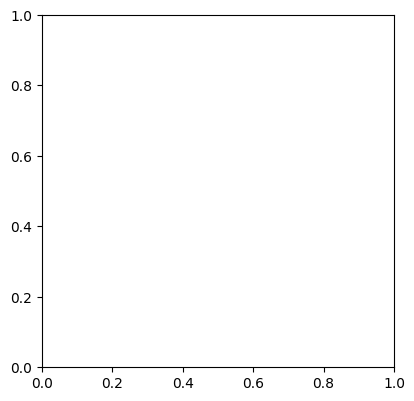

In [131]:
# generate image
vae_model.eval()
with torch.no_grad():
    for inputs, _ in test_typical_loader:
        reconstructions = vae_model(inputs)
        inputs = inputs.squeeze(0)
        reconstructions = reconstructions.squeeze(0)
        break

# take first 3 channels and plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
print(inputs.squeeze(0).numpy().shape)
plt.imshow(inputs.squeeze(0).numpy(), cmap="gray")
plt.title("Original")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(reconstructions.squeeze(0).numpy(), cmap="gray")
plt.title("Reconstruction")
plt.axis("off")
plt.show()

print(reconstructions)

In [6]:
import torch

# save the model
torch.save(vae_model.state_dict(), "vae_model.pth")

In [9]:
# load the model
vae_model = VariationalAutoencoder(
    n_data_features=28 * 28,  # MNIST pixels
    n_encoder_hidden_features=128,
    n_decoder_hidden_features=128,
    n_latent_features=10,  # how many features will be used to represent input
)
vae_model.load_state_dict(torch.load("vae_model.pth"))

<All keys matched successfully>